In [1]:
import pandas as pd
import numpy as np

## 1. Load & Explore Dataset

In [2]:
df = pd.read_csv("data/reply_classification_dataset.csv")
df.head()

,reply,label
0,Can we discuss pricing??,NEUTRAL
1,"Im excited to explore this further, plz send c...",POSITIVE
2,We not looking for new solutions.,negative
3,Could u clarify features included?,neutral
4,"lets,, schedule a meeting to dive deeper",positive


In [3]:
# Basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   reply   2129 non-null   object
 1   label   2129 non-null   object
dtypes: object(2)
memory usage: 33.4+ KB


In [4]:
# Check missing values
df.isnull().sum()

,0
reply,0
label,0


In [5]:
# Class distribution
df['label'].value_counts()

,count
label,
neutral,704
positive,446
NEGATIVE,267
POSITIVE,263
Negative,254
negative,189
Neutral,3
NEUTRAL,2
Positive,1


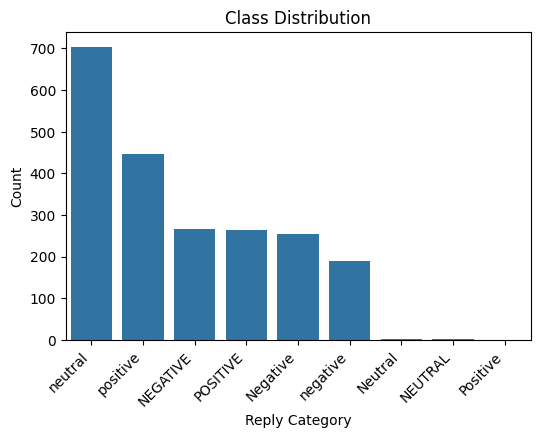

In [6]:
# Plot class distribution
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, order=df['label'].value_counts().index)
plt.title("Class Distribution")
plt.xlabel("Reply Category")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')

plt.show()

In [7]:
df['label'].unique()

array(['NEUTRAL', 'POSITIVE', 'negative', 'neutral', 'positive',
       'NEGATIVE', 'Positive', 'Neutral', 'Negative'], dtype=object)

## 2. Preprocessing

In [ ]:
import re
# Normalize labels
df['label'] = df['label'].str.lower().str.strip()


/tmp/ipython-input-4119870518.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, order=df['label'].value_counts().index,palette='Set2')


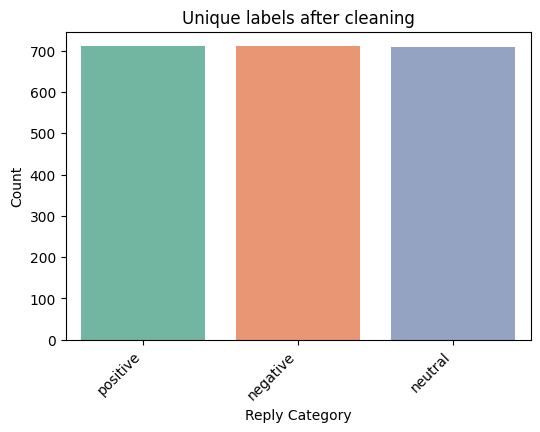

In [9]:
# Plot class distribution
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, order=df['label'].value_counts().index,palette='Set2')
plt.title("Unique labels after cleaning")
plt.xlabel("Reply Category")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')

plt.show()

In [10]:
print("Unique labels after cleaning:", df['label'].unique())
print(df['label'].value_counts())

Unique labels after cleaning: ['neutral' 'positive' 'negative']
label
positive    710
negative    710
neutral     709
Name: count, dtype: int64


In [11]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.0 MB/s eta 0:00:00


In [12]:
import re
import contractions

# Slang replacements
slang_dict = {
    "plz": "please",
    "u": "you",
    "thx": "thanks",
    "gr8": "great"
}

# Common typo/variant corrections
typo_dict = {
    "intrest": "interest",
    "intrested": "interested",
    "intrsted": "interested",
    "alredy": "already",
    "schdule": "schedule",
    "oppurtunity": "opportunity"
}

# Basic text cleaning function
def clean_text(text):
    # Expand contractions (e.g. "can't" -> "cannot")
    text = contractions.fix(str(text))
    # Lowercase and strip spaces
    text = str(text).lower().strip()
    # Replace slang
    text = " ".join([slang_dict.get(word, word) for word in text.split()])
    # Replace typos/variants
    text = " ".join([typo_dict.get(word, word) for word in text.split()])
    # Remove punctuation/special characters
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)
    return text


In [13]:
df['clean_reply'] = df['reply'].apply(clean_text)
print('Cleaned Dataset')
df.head()

Cleaned Dataset


,reply,label,clean_reply
0,Can we discuss pricing??,neutral,can we discuss pricing
1,"Im excited to explore this further, plz send c...",positive,i am excited to explore this further please se...
2,We not looking for new solutions.,negative,we not looking for new solutions
3,Could u clarify features included?,neutral,could you clarify features included
4,"lets,, schedule a meeting to dive deeper",positive,let us schedule a meeting to dive deeper


## 3. Train-Test Split
### Split cleaned dataset into training and testing sets, save for future use.

In [ ]:
from sklearn.model_selection import train_test_split
import os

# Train/test split
X = df['clean_reply']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Create directories if not exists
os.makedirs('data', exist_ok=True)

# Save to CSV
train_df = pd.DataFrame({'reply': X_train, 'label': y_train})
test_df = pd.DataFrame({'reply': X_test, 'label': y_test})

train_df.to_csv('data/train_replies.csv', index=False)
test_df.to_csv('data/test_replies.csv', index=False)

print("Train and Test datasets saved:")
print(" - data/train_replies.csv")
print(" - data/test_replies.csv")


Train and Test datasets saved:
 - data/train_replies.csv
 - data/test_replies.csv


### Load saved train/test datasets

In [15]:
# Load pre-saved train/test datasets
train_df = pd.read_csv('data/train_replies.csv')
test_df = pd.read_csv('data/test_replies.csv')

X_train = train_df['reply']
y_train = train_df['label']

X_test = test_df['reply']
y_test = test_df['label']

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 1703, Testing samples: 426


## 4.  Corpus Analysis
### Analyze word counts and sentence lengths to decide TF-IDF and BERT parameters.

In [16]:
from collections import Counter

# Count unique words in training corpus
word_counts = Counter(" ".join(train_df["reply"]).split())
print(f"Total unique words in training set: {len(word_counts)}")

# Inspect most common words
print("Top 10 most common words:", word_counts.most_common())

# Sentence length distribution
sentence_lengths = train_df["reply"].apply(lambda x: len(x.split()))
print("\nSentence length stats:")
print(sentence_lengths.describe())  # min, mean, median, max


Total unique words in training set: 214
Top 10 most common words: [('to', 333), ('send', 308), ('not', 289), ('please', 286), ('you', 272), ('this', 261), ('can', 255), ('i', 214), ('for', 199), ('no', 198), ('in', 186), ('us', 182), ('am', 173), ('share', 171), ('let', 158), ('demo', 151), ('need', 132), ('love', 127), ('id', 113), ('provide', 103), ('feature', 99), ('pricing', 99), ('could', 98), ('product', 95), ('fit', 94), ('interested', 82), ('interest', 82), ('right', 80), ('the', 75), ('w', 73), ('solution', 71), ('discuss', 71), ('team', 70), ('schedule', 66), ('structure', 65), ('excited', 64), ('now', 64), ('guide', 64), ('week', 63), ('see', 63), ('more', 61), ('eager', 55), ('review', 55), ('proposal', 54), ('set', 52), ('were', 52), ('up', 51), ('open', 51), ('list', 50), ('explore', 50), ('a', 49), ('sounds', 49), ('cost', 48), ('vendors', 48), ('good', 47), ('meeting', 46), ('me', 45), ('next', 44), ('happy', 43), ('setup', 42), ('breakdown', 41), ('service', 41), ('sup

- Vocabulary size: 214 unique words → so we can safely set max_features=215

- Sentence length: mostly 3–5 words, max 10 → so bigrams (ngram_range=(1,1)) are fine

## 5. Build TF-IDF + Logistic Regression pipeline
### Build a simple pipeline as a baseline and evaluate performance.

Baseline Model Accuracy: 0.9977
Baseline Model Weighted F1: 0.9977

Classification Report:
               precision    recall  f1-score   support

    negative       1.00      1.00      1.00       142
     neutral       1.00      0.99      1.00       142
    positive       0.99      1.00      1.00       142

    accuracy                           1.00       426
   macro avg       1.00      1.00      1.00       426
weighted avg       1.00      1.00      1.00       426



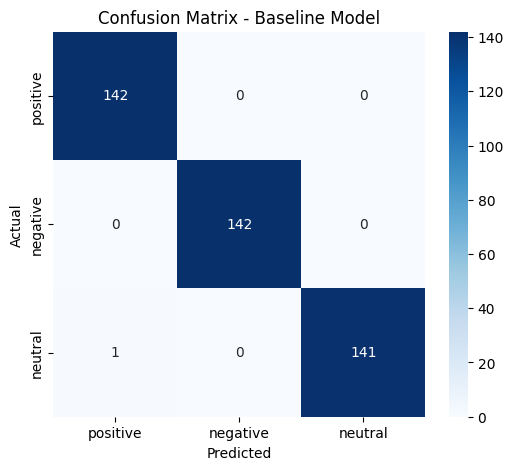

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

# Use max_features slightly higher than vocabulary size
MAX_FEATURES = 215

# Build TF-IDF + Logistic Regression pipeline
baseline_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,1), max_features=MAX_FEATURES)),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

# Train baseline model
baseline_pipe.fit(X_train, y_train)

# Predictions
y_pred = baseline_pipe.predict(X_test)

# Evaluation
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Baseline Model Accuracy: {acc:.4f}")
print(f"Baseline Model Weighted F1: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=['positive', 'negative', 'neutral'])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['positive', 'negative', 'neutral'],
            yticklabels=['positive', 'negative', 'neutral'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Baseline Model')
plt.show()

### Save baseline model

In [18]:
import joblib
os.makedirs('models', exist_ok=True)

# Save baseline model
joblib.dump(baseline_pipe, 'models/baseline_model.joblib')
print("Baseline model saved as 'models/baseline_model.joblib'")

Baseline model saved as 'models/baseline_model.joblib'


##  Prediction Baseline 
### load the saved baseline model and make prediction


In [28]:
# Load the saved baseline model
baseline_pipe = joblib.load('models/baseline_model.joblib')

# New single text
new_text = "I love this product!"

# Predict label
pred_label = baseline_pipe.predict([new_text])[0]

# Predict probabilities (optional)
pred_prob = baseline_pipe.predict_proba([new_text])[0]

print(f"Text: {new_text}")
print(f"Predicted label: {pred_label}")
print(f"Prediction probabilities: {pred_prob}")

Text: I love this product!
Predicted label: positive
Prediction probabilities: [0.08502571 0.07011655 0.84485774]


## 6. Fine-tune DistilBERT

based on Stats :
std         1.236890

min         3.000000

25%         4.000000

50%         5.000000

75%         5.000000

max        10.000000

- So most sentences(75%) are <=5 words
- BERT adds 2 special tokens [CLS] and [SEP] → length = num_words + 2
- dataset max length = 10 → so max_length=10–15 is sufficient.

In [19]:
from datasets import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score
from transformers import EarlyStoppingCallback


# Define label mapping
label2id = {"positive": 0, "negative": 1, "neutral": 2}
id2label = {v: k for k, v in label2id.items()}

# Map labels in your pandas DataFrame directly
train_df["labels"] = train_df["label"].map(label2id)
test_df["labels"] = test_df["label"].map(label2id)

train_dataset = train_df.drop(columns=["label"])
test_dataset = test_df.drop(columns=["label"])

# Convert train/test into Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_dataset)
test_dataset = Dataset.from_pandas(test_dataset)

# Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["reply"], padding="max_length", truncation=True, max_length=12)

train_dataset = train_dataset.map(tokenize)
test_dataset = test_dataset.map(tokenize)


# Load model
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    save_strategy="epoch",
    eval_strategy="epoch",       # must evaluate to compute metric
    per_device_train_batch_size=8,
    num_train_epochs=15,
    load_best_model_at_end=True,       # automatically load best model
    metric_for_best_model="f1",        # metric to monitor
    report_to="none"
)



# Define metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

# Train
trainer.train()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/1703 [00:00<?, ? examples/s]

Map:   0%|          | 0/426 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4024966042.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.000573,1.000000,1.000000
2,No log,0.000181,1.000000,1.000000
3,0.040000,0.000088,1.000000,1.000000
4,0.040000,0.000054,1.000000,1.000000
5,0.000100,0.000036,1.000000,1.000000
6,0.000100,0.000026,1.000000,1.000000


TrainOutput(global_step=1278, training_loss=0.015693592159033803, metrics={'train_runtime': 81.1594, 'train_samples_per_second': 314.751, 'train_steps_per_second': 39.367, 'total_flos': 31724437925232.0, 'train_loss': 0.015693592159033803, 'epoch': 6.0})

In [20]:
# Evaluate
metrics = trainer.evaluate()
print(metrics)


{'eval_loss': 0.0005726959207095206, 'eval_accuracy': 1.0, 'eval_f1': 1.0, 'eval_runtime': 0.3976, 'eval_samples_per_second': 1071.317, 'eval_steps_per_second': 135.801, 'epoch': 6.0}


Save the DistilBERT Model

In [22]:
model.save_pretrained("models/bert_reply_classifier")
tokenizer.save_pretrained("models/bert_reply_classifier")

('models/bert_reply_classifier/tokenizer_config.json',
 'models/bert_reply_classifier/special_tokens_map.json',
 'models/bert_reply_classifier/vocab.txt',
 'models/bert_reply_classifier/added_tokens.json',
 'models/bert_reply_classifier/tokenizer.json')

## Prediction DistilBERT
### load saved DistilBERT model

In [27]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

# Path to the folder where you saved both
model_path = "models/bert_reply_classifier"

# Load model + tokenizer back
model = DistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)

# Test prediction
text = "I love this product!"
cleaned_text = clean_text(text)

inputs = tokenizer(cleaned_text, return_tensors="pt", padding=True, truncation=True)
outputs = model(**inputs)
pred = outputs.logits.argmax(dim=-1).item()

print("Predicted label:", model.config.id2label[pred])


Predicted label: positive
